In [1]:
#!pip install eli5 

In [2]:
# IMPORTING lIBRARIES

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from imblearn.under_sampling import RandomUnderSampler
import eli5

import IPython
from IPython.display import display
import graphviz
from sklearn.tree import export_graphviz
import re


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

# DATA EXPLORATION

In [4]:
#pd.read_csv() reads the csv file and gives Pandas DataFrame.
# sep='\t' used to read the files which are in .tsv format
lines_df = pd.read_csv('movie_lines.tsv', sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)
characters_df = pd.read_csv('movie_characters_metadata.tsv', sep='\t', 
                            warn_bad_lines=False, error_bad_lines=False, header=None)

characters_df.head()

,0,1,2,3,4,5
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [5]:
lines_df.head()   #gives first 5 rows in dataset

,0,1,2,3,4
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [6]:
#Adding column names to characters dataframe
characters_df.columns=['chId','chName','mId','mName','gender','posCredits']
characters_df.head()

,chId,chName,mId,mName,gender,posCredits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [7]:
characters_df.shape

(9034, 6)

In [8]:
#Checking the distribution of gender in the characters dataset
characters_df.gender.value_counts()

?    6008
m    1899
f     921
M     145
F      44
Name: gender, dtype: int64

In [9]:
#We’ll assign a label of 0 to male characters & 1 to female characters.
characters_df = characters_df[characters_df.gender != '?']
characters_df.gender = characters_df.gender.apply(lambda g: 0 if g in ['m', 'M'] else 1)  ## Label encoding

characters_df.shape

(3026, 6)

In [10]:
characters_df.gender.value_counts()

0    2044
1     982
Name: gender, dtype: int64

In [11]:
#position of the character in the post credits of the movie
characters_df.posCredits.value_counts()

1       497
2       443
3       352
?       330
4       268
5       211
6       169
7       125
8       100
9        79
10       54
11       40
1000     38
13       33
12       32
16       26
14       24
18       24
17       19
19       18
15       14
21       13
22        9
20        8
29        7
27        6
25        5
24        5
26        5
23        4
35        4
31        4
45        4
33        3
34        3
38        3
43        3
30        2
39        2
59        2
32        2
42        2
36        2
28        2
37        1
41        1
63        1
71        1
50        1
82        1
62        1
47        1
44        1
46        1
51        1
70        1
49        1
Name: posCredits, dtype: int64

In [12]:
#combine the low frequency ones together first
characters_df.posCredits = characters_df.posCredits.apply(lambda p: '10+' if not p in ['1', '2', '3', '4', '5', '6', '7', '8', '9'] else p)  ## Label encoding
characters_df.posCredits.value_counts()

10+    782
1      497
2      443
3      352
4      268
5      211
6      169
7      125
8      100
9       79
Name: posCredits, dtype: int64

In [13]:
# Adding the column names 
lines_df.columns = ['lineId','chId','mId','chName','dialogue']
lines_df.head()

,lineId,chId,mId,chName,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [14]:
#join lines_df and characters_df together based on 'chId','mId', 'chName' So each character has his own data
#for eg all dialogues of Bianca will be sorted and vice versa
df = pd.merge(lines_df, characters_df, how='inner', on=['chId','mId', 'chName'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df.head()

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4


In [15]:
#gives no. rows of the data or length of data
df.shape

(229309, 8)

In [16]:
df['dialogue'].notnull()

0         True
1         True
2         True
3         True
4         True
          ... 
229304    True
229305    True
229306    True
229307    True
229308    True
Name: dialogue, Length: 229309, dtype: bool

In [17]:
#Remove empty dialogues from the dataset
# df['dialogue'].notnull() will give u data which are not null in form of true or false as above
# df[df['dialogue'].notnull()] will give u the exact data to be stored in variable and no null values will be there

df = df[df['dialogue'].notnull()]
df.shape

(229106, 8)

In [18]:
#check what kind of movie metadata we can add to our dataset. 
movies = pd.read_csv("movie_titles_metadata.tsv", sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)
movies.head()

,0,1,2,3,4,5
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [19]:
#Adding column names
movies.columns = ['mId','mName','releaseYear','rating','votes','genres']

movies.head()

,mId,mName,releaseYear,rating,votes,genres
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [20]:
#getting the columns which we want 
movie_yr = movies[['mId', 'releaseYear']]
movie_yr.head()

,mId,releaseYear
0,m0,1999
1,m1,1992
2,m2,2001
3,m3,1968
4,m4,1982


In [21]:
movie_yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mId          617 non-null    object
 1   releaseYear  616 non-null    object
dtypes: object(2)
memory usage: 9.8+ KB


In [22]:
#selecting year column which is string format to numerical 
#Using errors='coerce'. It will replace all non-numeric values with NaN
# movie_yr[movie_yr['releaseYear'].istnull()] give u whci row is null
movie_yr.releaseYear = pd.to_numeric(movie_yr.releaseYear.apply(lambda y: str(y)[0:4]), errors='coerce')
movie_yr = movie_yr.dropna()
movie_yr.head()

,mId,releaseYear
0,m0,1999.0
1,m1,1992.0
2,m2,2001.0
3,m3,1968.0
4,m4,1982.0


In [23]:
movie_yr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 0 to 616
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mId          616 non-null    object 
 1   releaseYear  616 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.4+ KB


In [24]:
#just add the year of movie release to our dataset.
# based on 'mId' COLUMN as it is the common column between two datasets so we get all data rows sorted according to mid
df = pd.merge(df, movie_yr, how='inner', on=['mId'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df.head()


,lineId,chId,mId,chName,dialogue,mName,gender,posCredits,releaseYear
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4,1999.0
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4,1999.0
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4,1999.0
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4,1999.0
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4,1999.0


# Feature Engineering 

**1.** Length of lines

**2.** Count of lines

**3.** One hot encodings for tokens

In [25]:
#above steps will be carried out to do feature enginnering of text based data

In [26]:
# lineLength and wordCountLine of dailogue will be added to that particular row
# df.dialogue gets us that dailogue column. Since its a string we use      str.len() 
df['lineLength'] = df.dialogue.str.len()             ## Length of each line by characters
df['wordCountLine'] = df.dialogue.str.count(' ') + 1 ## Length of each line by words
df.head()

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits,releaseYear,lineLength,wordCountLine
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4,1999.0,12,3
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4,1999.0,10,3
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4,1999.0,9,2
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4,1999.0,46,10
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4,1999.0,32,6


### convert the dialogues into clean tokens

**1.** Remove Stopwords : because they occur very often, but serve no meaning. For eg. : is,am,are,the.

**2.** Turn all word to smaller cases : I, i -> i

**3.** Lemmatization: convert words to their root form. For eg., walk,walks -> walk or geographical,geographic -> geographic

In [27]:
wordnet_lemmatizer = WordNetLemmatizer()
def clean_dialogue( dialogue ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review) 
    #
    # 1. Remove HTML
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", dialogue) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))   
    
    # 5. Use lemmatization and remove stop words
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

df['cleaned_dialogue'] = df['dialogue'].apply(clean_dialogue)
df[['dialogue','cleaned_dialogue']].sample(5)

,dialogue,cleaned_dialogue
126836,Why George you big softie...,george big softie
177457,Well that hotel begins construction in January...,well hotel begin construction january going lo...
205362,That's Carlotta Valdes.,carlotta valdes
27181,Now Mr. Smith now please,mr smith please
53817,Oh Jesus!!,oh jesus


## Create training dataset

Now, we can aggregate all data for a particular movie character into 1 record using groupby() function. We will combine their dialogue tokens from the entire movie, calculate their median dialogue length by characters & words, and count their total no of lines in the movie using agg()

In [28]:
df.tail() #gives last 5 rows of dataset

,lineId,chId,mId,chName,dialogue,mName,gender,posCredits,releaseYear,lineLength,wordCountLine,cleaned_dialogue
229101,L300355,u1468,m99,WILLIE,I'm going to puke in it...,indiana jones and the temple of doom,1,2,1984.0,26,6,going puke
229102,L300353,u1468,m99,WILLIE,Give me your hat...,indiana jones and the temple of doom,1,2,1984.0,19,4,give hat
229103,L300189,u1468,m99,WILLIE,Figures...,indiana jones and the temple of doom,1,2,1984.0,10,1,figure
229104,L300187,u1468,m99,WILLIE,This is the first time anybody ever cried when...,indiana jones and the temple of doom,1,2,1984.0,54,11,first time anybody ever cried left
229105,L300115,u1468,m99,WILLIE,You got it!,indiana jones and the temple of doom,1,2,1984.0,11,3,got


In [29]:
train = df.groupby(['chId', 'mId', 'chName', 'gender', 'posCredits','releaseYear']). \
            agg({'lineLength' : ['median'],                      #median of linelength col
                 'wordCountLine' : ['median'],                   #median of wordCountLine column
                 'chId' : ['count'],                             #counting chid 
                 'cleaned_dialogue' : [lambda x : ' '.join(x)]   
                })

## Renaming columns by aggregate functions
train.columns = ["_".join(x) for x in train.columns.ravel()]    #rename the column names with their respective aggregation type

train.reset_index(inplace=True)       #inplace=True permanently does the changes
train

,chId,mId,chName,gender,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
0,u0,m0,BIANCA,1,4,1999.0,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,u100,m6,AMY,1,7,1999.0,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,u1003,m65,RICHARD,0,3,1996.0,24.5,5.0,70,asked would said room room serious foolin arou...
3,u1005,m65,SETH,0,2,1996.0,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,u1008,m66,C.O.,0,10+,1997.0,48.0,9.0,33,course uh v p security arrangement generally t...
...,...,...,...,...,...,...,...,...,...,...
2946,u980,m63,VICTOR,0,3,1931.0,32.0,6.0,126,never said name remembers kill draw line take...
2947,u983,m64,ALICE,1,10+,2009.0,30.0,6.0,51,maybe wait mr christy killer still bill bill b...
2948,u985,m64,BILL,0,10+,2009.0,20.0,4.0,39,twenty mile crossroad steve back hour thing st...
2949,u997,m65,JACOB,0,1,1996.0,36.0,6.0,90,meant son daughter oh daughter bathroom vacati...


In [30]:
#some feature distributions by gender

# Data Visualisation 

Using Seaborn library to view our data and explain our data and relationships better 

In [31]:
#Bivarient analysis - understanding relation of one column with another column

In [32]:
#those black dots are called Outliers which affect our Model. Solving them can improve the accuracy of our model well.Since its text base data we will get more outliers

<AxesSubplot:xlabel='gender', ylabel='chId_count'>

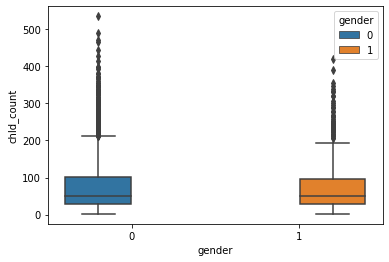

In [33]:
sns.boxplot(data = train, x = 'gender', y = 'chId_count', hue = 'gender')

##### The chId_count here refers to the no of lines given to the character in the movie. While the median value seems to be roughly similar for both males & females, the upper bound seems to be higher for males.

<AxesSubplot:xlabel='gender', ylabel='wordCountLine_median'>

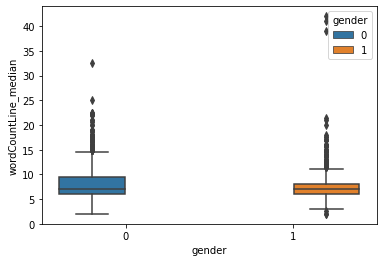

In [34]:
sns.boxplot(data = train, x = 'gender', y = 'wordCountLine_median', hue = 'gender')

##### The count of words per dialogue is higher for male characters than that for female characters!

<AxesSubplot:xlabel='gender', ylabel='lineLength_median'>

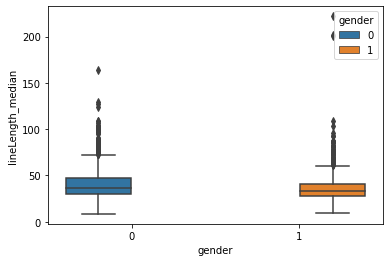

In [35]:
sns.boxplot(data = train, x = 'gender', y = 'lineLength_median', hue = 'gender')

##### The median length of a dialogue also seems to be higher for males.

<AxesSubplot:xlabel='wordCountLine_median', ylabel='chId_count'>

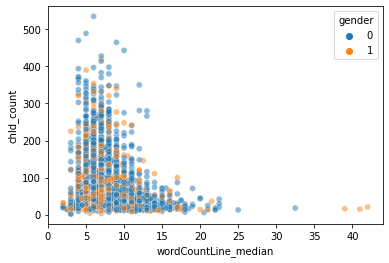

In [36]:
sns.scatterplot(data = train, x = 'wordCountLine_median', y = 'chId_count', hue = 'gender', alpha = 0.5)

#### Again, in the scatter plot, we see female characters, ie yellow points, generally closer to the origin, as they have smaller dialogues & lesser dialogues per movie, while male characters denoted by blue dots are more outward from the origin.

In [37]:
#Train test split
## Separating labels from features

In [38]:
# X will be  our independent columns but will not have target variable so we drop "gender" column,
# y will always be our dependent column or target variable ,here is "gender"
# we also dropped unwanted columns which are not needed while training the model like chId, mId, chName
y = train['gender']
X = train.copy()
X.drop('gender', axis=1, inplace=True)

## Removing unnecessary columns
X.drop('chId', axis=1, inplace=True)
X.drop('mId', axis=1, inplace=True)
X.drop('chName', axis=1, inplace=True)
X.head()

,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
0,4,1999.0,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999.0,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996.0,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996.0,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,10+,1997.0,48.0,9.0,33,course uh v p security arrangement generally t...


In [39]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: gender, dtype: int64

In [40]:
#We will pick equal no of records for both male & female characters to avoid any kind of bias due to no of records
# using RandomUnderSampler

In [41]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
y_under.value_counts()       #equal counts of male n female

0    948
1    948
Name: gender, dtype: int64

In [42]:
#We’ll also try to keep equal no of male & female records in the train & validation datasets

In [43]:
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, 
# stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
X_train, X_val, y_train, y_val = train_test_split(X_under, y_under, test_size=0.2, random_state = 10, stratify=y_under)

y_val.value_counts()

0    190
1    190
Name: gender, dtype: int64

In [44]:
y_train.value_counts()

0    758
1    758
Name: gender, dtype: int64

In [45]:
X_val.head()

,posCredits,releaseYear,lineLength_median,wordCountLine_median,chId_count,cleaned_dialogue_<lambda>
1236,2,2001.0,33.0,6.0,60,latitude degree maybe satellite said three ye...
924,10+,1974.0,35.0,7.0,15,lucky c note new deal maybe yes maybe michael ...
868,2,2000.0,31.5,6.5,108,go free anything need come visit sure wanna s...
363,1,1949.0,22.0,4.0,204,anyway quarrel getting oh well headache course...
989,10+,2000.0,42.0,8.0,15,okay took trouble come got principle selling o...


# Pipeline for classifiers

Data pipelines allow you transform data from one representation to another through a series of steps. It is used to chain multiple estimators into one and hence, automate the machine learning process. the purpose of a pipeline is to allow you to increase the iteration cycle with the added confidence that codifying the process gives and to scale how many models you can realistically maintain in production.

#### Since our dataset includes both numerical features & NLP tokens, we’ll use a special converter class in our pipeline.

In [46]:
#fit and transform method used in Parent class and will be used by child class
class Converter(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

In [47]:
#Pipeline for numeric features
# MinMaxScaler class of sklearn. preprocessing is used for normalization of features.
# to change the values of numeric columns in the dataset to a common scale, 
# without distorting differences in the ranges of values 
numeric_features = ['lineLength_median', 'wordCountLine_median', 'chId_count', 'releaseYear']

numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

In [48]:
#Pipeline for tokens dereived from dialogues
# One-hot encoding is essentially the representation of categorical variables as binary vectors. ... 
# These categorical values are first mapped to integer values. Each integer value is then 
# represented as a binary vector that is all 0s and 1s.
categorical_features = ['posCredits']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [49]:
# TfidfVectorizer() used for dealing with vectors text of  " cleaned_dialogue_<lambda> "column , 
#'tf' is the alias name and 'con' for Converter is our Parent class
# Term Frequency-Inverse Document Frequency is used to evaluate how important a word is to a document in a collection
# This method is powerful when dealing with an important number of stopwords  I, me, my, myself, we, our, ours, ourselves, you
vectorizer_features = ['cleaned_dialogue_<lambda>']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

## We can combine preprocessing pipelines with the classifers. We will try 4  models:

**1.** Linear Support Vector Classifier

**2.** Logistic Regression Classifier

**3.** Random Forest Clasifier

**4.** XGBoost

In [50]:
import xgboost

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),                   #numeric features
        ('cat', categorical_transformer, categorical_features),           #categorical_features
        ('vec', vectorizer_transformer, vectorizer_features)              #cleaned_dialogue_<lambda> col
    ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', CalibratedClassifierCV(LinearSVC()))])  ## LinearSVC has no predict_proba method

log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8))])

xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=5000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1))])


In [52]:
#Fitting the preprocessing & classifier pipelines on training data ,we are training the model using X_train and y_train and fit()
svc_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lineLength_median',
                                                   'wordCountLine_median',
                                                   'chId_count',
                                                   'releaseYear']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['posCredits']),
                                                 ('vec',
                                                  Pipeline(steps=[('con',
                         

In [53]:
#Check results on the validation set
def results(name: str, model: BaseEstimator) -> None:
    '''
    Custom function to check model performance on validation set
    '''
    preds = model.predict(X_val)   # predicting model with pred() and X_val

    print(name + " score: %.3f" % model.score(X_val, y_val))
    print(classification_report(y_val, preds))
    labels = ['Male', 'Female']

    conf_matrix = confusion_matrix(y_val, preds)
    plt.figure(figsize= (10,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix for " + name)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

SVC score: 0.742
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       190
           1       0.74      0.74      0.74       190

    accuracy                           0.74       380
   macro avg       0.74      0.74      0.74       380
weighted avg       0.74      0.74      0.74       380

Logistic Regression score: 0.745
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       190
           1       0.74      0.76      0.75       190

    accuracy                           0.74       380
   macro avg       0.74      0.74      0.74       380
weighted avg       0.74      0.74      0.74       380

Random Forest score: 0.682
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       190
           1       0.67      0.72      0.69       190

    accuracy                           0.68       380
   macro avg       0.68      0.68      0.68       3

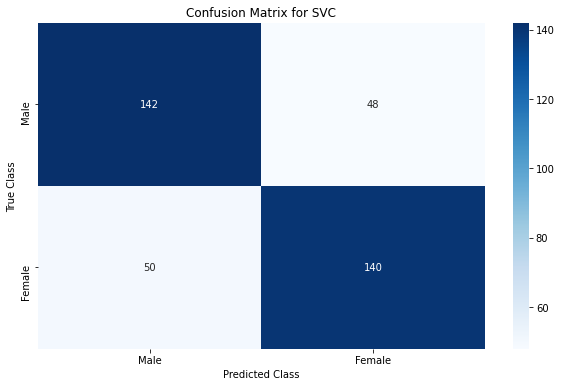

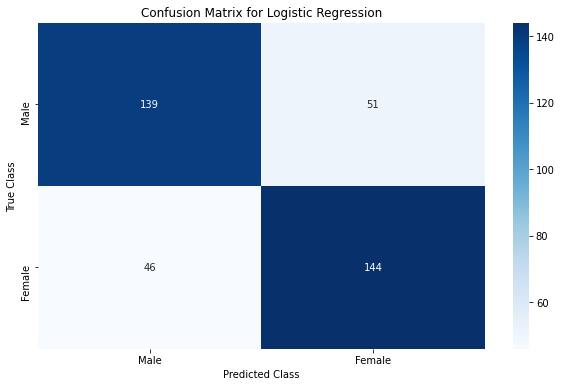

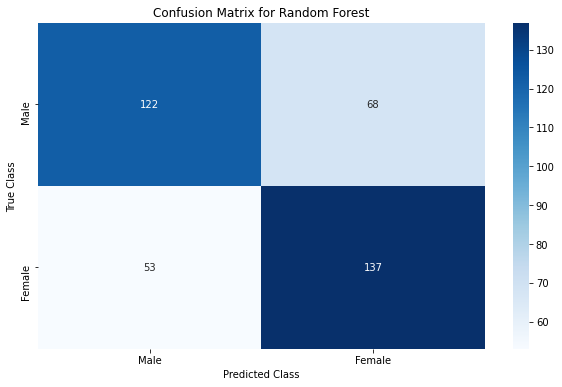

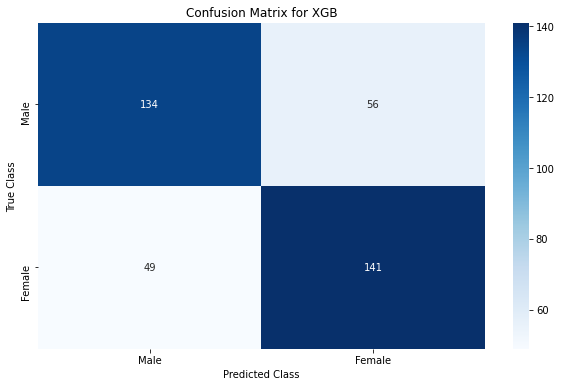

In [54]:
results("SVC" , svc_clf)
results("Logistic Regression" , log_clf)
results("Random Forest" , rf_clf)
results("XGB" , xgb)

We see that Linear SVC performs the best classification with an accuracy & F1 score of ~79% !!

From the confusion matrix, we can see that out of the 190 male characters in the validation dataset, SVC model classified 155 of them correctly as males, and the remaining 35 incorrectly as females. Similarly, out of 190 female characters in the validation dataset, 144 were classified correctly & 46 classified incorrectly.

Logistic Regression & Naive Bayes classifiers are close at 77% & 76% accuracies respectively. These results are not close to state of the art, but are still pretty good.

Let’s now explore what features contribute the most to our classifiers performance through some model explainability techniques.

# Feature importance

#### Creating a list of all features including numeric, categorical & vectorised features.

In [55]:
vect_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['vec'].named_steps['tf'].get_feature_names())
onehot_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(vect_columns)

In [56]:
# Feature importance for Logistic Regression
lr_weights = eli5.explain_weights_df(log_clf.named_steps['classifier'], top=30, feature_names=numeric_features_list)
lr_weights.head(15)

,target,feature,weight
0,1,oh,2.589627
1,1,really,1.368830
2,1,like,1.368708
3,1,want,1.306609
4,1,hi,1.106837
5,1,please,1.050864
6,1,darling,1.045922
7,1,love,1.023836
8,1,said,1.018255
9,1,baby,0.998029


In [57]:
lr_weights.tail(14)

,target,feature,weight
16,1,money,-0.875810
17,1,chId_count,-0.882841
18,1,lineLength_median,-0.942719
19,1,good,-0.951328
20,1,guy,-1.013563
21,1,look,-1.073765
22,1,ya,-1.143304
23,1,gotta,-1.175563
24,1,hell,-1.225489
25,1,fuckin,-1.233903


We see that dialogue keywords like oh, love, like, darling, want, honey are strong indicators that the character is a female, while keywords like son, sir, man, hell, gotta, yeah & most cuss words are usually found in the dialogues of male characters of the given Hollywood movies!

Let’s also try to visualize a single decision tree
We can training a single decision tree using the Random Forest Classifier.

Decision Tree Classifier score: 0.553
              precision    recall  f1-score   support

           0       0.53      0.85      0.66       190
           1       0.63      0.25      0.36       190

    accuracy                           0.55       380
   macro avg       0.58      0.55      0.51       380
weighted avg       0.58      0.55      0.51       380



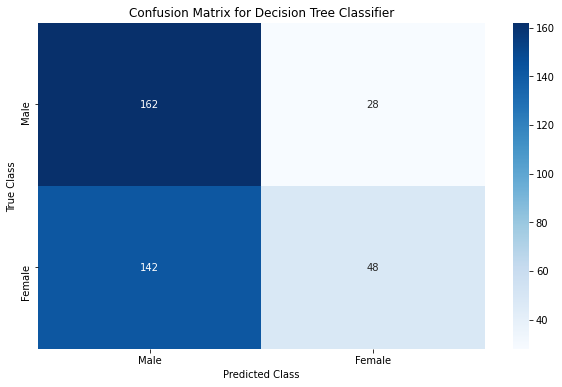

In [58]:
m = RandomForestClassifier(n_estimators=1, min_samples_leaf=5, max_depth = 3, 
                           oob_score=True, random_state = np.random.seed(123))
dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', m)])

dt_clf.fit(X_train, y_train)
results("Decision Tree Classifier", dt_clf)

While a single decision is a poor classifier with accuracy barely more than 50%, we see that bagging enough of such weak classifiers to form a Random Forest model helps us improve the model performance drastically! Let’s look at how the splits are made for a single decision tree.

In [59]:
#!conda install python-graphviz

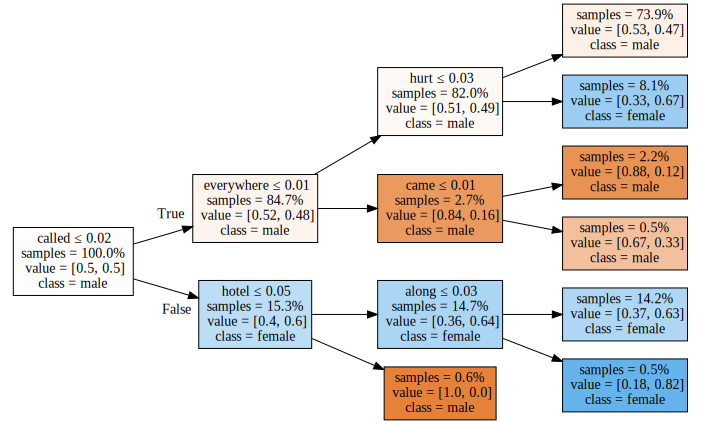

In [60]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ 
    Draws a representation of a decition tree in IPython from fastai v0.7
    """
    s=export_graphviz(t, out_file=None, feature_names=numeric_features_list, filled=True,
                      special_characters=True, rotate=True, precision=precision, 
                      proportion=True, class_names = ["male", "female"], impurity = False)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

draw_tree(m.estimators_[0], X_train, precision=2)

Here, the blue coloured nodes indicate their majority class is female while the orange colored nodes have a majority of male labels. The decision tree starts with a mixed sample, but the leaves of the tree are biased towards one class or the other. Most splits seem to be happening using dialogue tokens. For eg., in the above tree, if the tf-idf frequency of keywords think is > 0.1 & kid is > 0.03, the samples are classified as female.

In [61]:
#Feature importance for the Random Forest model
eli5.explain_weights_df(rf_clf.named_steps['classifier'], top=30, feature_names=numeric_features_list)

,feature,weight,std
0,em,0.014148,0.059049
1,really,0.011459,0.047610
2,shit,0.010488,0.049445
3,lineLength_median,0.010414,0.042951
4,may,0.008746,0.034498
5,oh,0.007969,0.045175
6,god,0.007635,0.031052
7,cop,0.007635,0.036157
8,love,0.007493,0.037166
9,head,0.007355,0.032059


We see that the median length of a dialogue, total no of lines (chId_count) & movie release year are important features along with the tokens extracted from the character’s dialogues for the Random Forest model!

In [62]:
# predicting the model 

In [63]:
#svc

In [64]:
y_pred_svc = svc_clf.predict(X_val)

In [65]:
svc_clf.score(X_val,y_val)

0.7421052631578947

In [66]:
print(classification_report(y_val, y_pred_svc, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       190
           1       0.74      0.74      0.74       190

    accuracy                           0.74       380
   macro avg       0.74      0.74      0.74       380
weighted avg       0.74      0.74      0.74       380



In [67]:
#LOGISTIC

In [68]:
y_pred_log =  log_clf.predict(X_val)

In [69]:
log_clf.score(X_val,y_val)

0.7447368421052631

In [70]:
print(classification_report(y_val, y_pred_log, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       190
           1       0.74      0.76      0.75       190

    accuracy                           0.74       380
   macro avg       0.74      0.74      0.74       380
weighted avg       0.74      0.74      0.74       380



In [71]:
#Random Forest

In [72]:
y_pred_rf =rf_clf.predict(X_val)

In [73]:
rf_clf.score(X_val,y_val)

0.6815789473684211

In [74]:
print(classification_report(y_val, y_pred_rf, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       190
           1       0.67      0.72      0.69       190

    accuracy                           0.68       380
   macro avg       0.68      0.68      0.68       380
weighted avg       0.68      0.68      0.68       380



In [75]:
#XGB

In [76]:
y_pred=xgb.predict(X_val)

In [77]:
xgb.score(X_val,y_val)

0.7236842105263158

In [78]:
print(classification_report(y_val, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       190
           1       0.72      0.74      0.73       190

    accuracy                           0.72       380
   macro avg       0.72      0.72      0.72       380
weighted avg       0.72      0.72      0.72       380

